In [1]:
import numpy as np
import scipy.io as sio
from scipy.sparse import lil_matrix
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json

import time
from time import perf_counter
import sklearn.metrics as skmet

In [27]:
with open("./config.json") as c:
            config = json.load(c)
            garden_points_db_path = config["garden_points_db"]
            garden_points_matrix_path = config["garden_points_matrix"]
            garden_query_points_path = config["garden_query_points"]
            raw_data_db = config["raw_garden_points_db"]
            raw_data_query = config["raw_garden_query_points"]
            garden_gt_data = config["garden_ground_truth"]
            
            nl_summer_raw_path = config["nl_summer_raw"]
            nl_spring_raw_path = config["nl_spring_raw"]
            nl_winter_raw_path = config["nl_winter_raw"]
            nl_fall_raw_path = config["nl_fall_raw"]
            
            nl_summer_mat_path = config["nl_summer_matrix"]
            nl_spring_mat_path = config["nl_spring_matrix"]
            nl_winter_mat_path = config["nl_winter_matrix"]
            nl_fall_mat_path = config["nl_fall_matrix"]
            
            nl_summer_seer_path = config["nl_summer_seer"]
            nl_spring_seer_path = config["nl_spring_seer"]
            nl_winter_seer_path = config["nl_winter_seer"]
            nl_fall_seer_path = config["nl_fall_seer"]

In [3]:
DS = sp.load_npz(garden_points_db_path)
Q = sp.load_npz(garden_query_points_path)

In [4]:
def sequential_cos_sim(db, q):
    #for x in range(db.shape[0]):
        #for y in range(q.shape[0]):
            #sim = skmet.pairwise.cosine_similarity(x,y)
    return skmet.pairwise.cosine_similarity(db,q)

In [5]:
def print_gs_matrix(matrix):
    plt.imshow(matrix, cmap='gray')
    plt.colorbar()
    plt.show()

In [6]:
cos_sim = sequential_cos_sim(DS, Q)
print_gs_matrix(cos_sim)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 6728 while Y.shape[1] == 6712

In [7]:
#from pyLSHash import LSHash

In [8]:
#lsh = LSHash(hash_size=6, input_dim=DS.shape[1])

In [9]:
#didn't work
def lshash_try():
    result_Matrix = np.empty((Q.shape[0], DS.shape[0]), dtype=int) 
    for x in range(DS.shape[0]):
        lsh.index(DS[x].toarray())
    for y in range(Q.shape[0]):
        res = lsh.query(q[y].toarray())
        for r in range(len(res)):
            result_Matrix[y][x] = res[r][1]

In [10]:
#didn't work, arrays are unhashable
from pyLSHash import SimHash, hamming

def sim_hash_try():
    sim_hash = SimHash()
    
    result_Matrix = np.empty((Q.shape[0], DS.shape[0]), dtype=np.float32)
    hashesD = np.empty(DS.shape[0])
    hashesQ = np.empty(Q.shape[0])
    for x in range(DS.shape[0]):
        hashesD[x] = sim_hash.get_hash(DS[x])
    for y in range(Q.shape[0]):
        hashesQ[y] = sim_hash.get_hash(Q[y])
    for x1 in range(DS.shape[0]):
        for y1 in range(Q.shape[0]):
            corr = 1 - hamming(hashesD[x1], hashesQ[y1]) / sim_hash.len_hash
            result_Matrix[y1][x1] = corr
    return result_Matrix


In [11]:
#didn't work, arrays are unhashable
from pyLSHash import min_hash

def sim_hash_try():
    sim_hash = SimHash()
    
    result_Matrix = np.empty((Q.shape[0], DS.shape[0]), dtype=np.float32)
    hashesD = np.empty(DS.shape[0])
    hashesQ = np.empty(Q.shape[0])
    for x in range(DS.shape[0]):
        hashesD[x] = sim_hash.get_hash(DS[x])
    for y in range(Q.shape[0]):
        hashesQ[y] = sim_hash.get_hash(Q[y])
    for x1 in range(DS.shape[0]):
        for y1 in range(Q.shape[0]):
            corr = 1 - hamming(hashesD[x1], hashesQ[y1]) / sim_hash.len_hash
            result_Matrix[y1][x1] = corr
    return result_Matrix


In [12]:
def fractional_distance(k, x1, x2):
    #test if x1 and x2 have equal length
    if (len(x1) != len(x2)):
        print('Input vectors have different lengths!')
        return
    else:
        sum = 0
        for i in range(len(x1)):
            sum += (np.abs(x1[i] - x2[i])) ** k
        return (sum ** (1/k))

In [13]:
def sequential_fractional_dist(Xin, Yin, k):
    result_Matrix = np.empty((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    for i in range(Xin.shape[0]):
        for j in range(Yin.shape[0]):
            dist = fractional_distance(k, Xin[i].toarray()[0], Yin[j].toarray()[0])
            result_Matrix[j][i] = dist
    return result_Matrix

In [16]:
start = perf_counter()
#results_fractional = sequential_fractional_dist(DS, Q, (2/5))
end = perf_counter()
duration = end - start
print(f"Duration Sequential fractional distances: {duration} seconds")

Duration Sequential fractional distances: 5.295799928717315e-05 seconds


In [15]:
def compute_matching_dimensions_sequential(Xin, Yin):
    result_Matrix = np.empty((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    for i in range(Xin.shape[0]):
        for j in range(Yin.shape[0]):
            matches = sum(ele in Xin[i].nonzero()[1] for ele in Yin[j].nonzero()[1])
            result_Matrix[j][i] = matches
    return result_Matrix

In [16]:
start = perf_counter()
results_match_dims = compute_matching_dimensions_sequential(DS, Q)
end = perf_counter()
duration = end - start
print(f"Duration Sequential matching dimensions: {duration} seconds")

Duration Sequential matching dimensions: 156.95656687500014 seconds


Text(0.5, 1.0, 'Cos - Matching Dims')

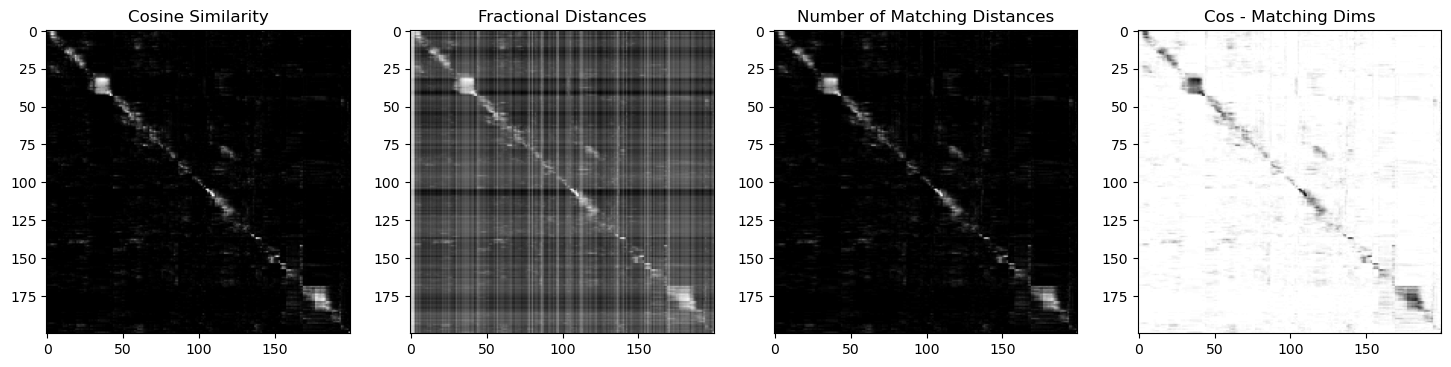

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18, 18))

ax1.imshow(np.transpose(cos_sim), cmap='gray')
ax1.set_title("Cosine Similarity")

ax2.imshow(results_fractional * -1, cmap='gray')
ax2.set_title("Fractional Distances")

ax3.imshow(results_match_dims, cmap='gray')
ax3.set_title("Number of Matching Distances")

ax4.imshow(np.transpose(cos_sim) - results_match_dims, cmap='gray')
ax4.set_title("Cos - Matching Dims")

In [18]:
DB_raw = sio.loadmat('./data/garden_points_raw/HDC_DELF_GardensPointWalking_day_left.mat')['Y']
Q_data_raw = sio.loadmat('./data/garden_points_raw/HDC_DELF_GardensPointWalking_night_right.mat')['Y']
gt = sio.loadmat('./data/garden_points_raw/groundTruth_GPW_DL_NR.mat')['GT']

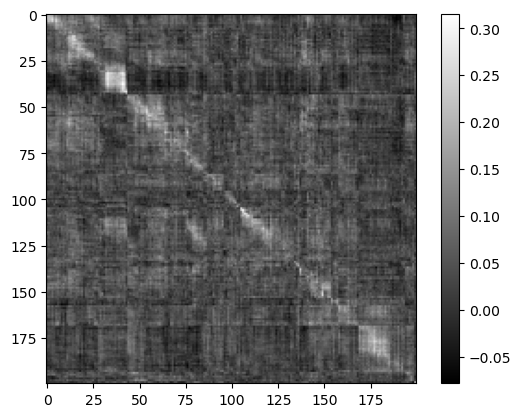

In [19]:
cos_sim_raw = sequential_cos_sim(DB_raw, Q_data_raw)
print_gs_matrix(cos_sim_raw)

In [20]:
def sequential_fractional_dist_raw_data(Xin, Yin, k):
    result_Matrix = np.empty((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    for i in range(Xin.shape[0]):
        for j in range(Yin.shape[0]):
            dist = fractional_distance(k, Xin[i], Yin[j])
            result_Matrix[j][i] = dist
    return result_Matrix

In [21]:
start = perf_counter()
results_fractional_raw = sequential_fractional_dist_raw_data(DB_raw, Q_data_raw, (2/5))
end = perf_counter()
duration = end - start
print(f"Duration Sequential fractional distances raw data: {duration} seconds")

Duration Sequential fractional distances raw data: 74.01894091600116 seconds


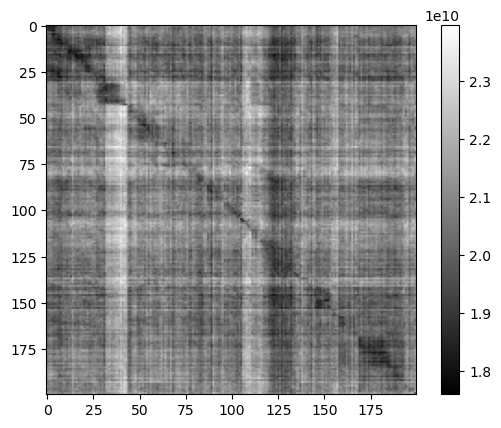

In [22]:
print_gs_matrix(results_fractional_raw)

In [23]:
import csv

with open('./data/SEER/DB_SEER_run2.csv', newline='') as csvfile:
    DB_SEER_2 = np.array(list(csv.reader(csvfile)), dtype='float')
    
with open('./data/SEER/Q_SEER.csv', newline='') as csvfile:
    Q_SEER_2 = np.array(list(csv.reader(csvfile)), dtype='float')
    
sparse_DB = lil_matrix(DB_SEER_2)
sparse_query = lil_matrix(Q_SEER_2)

In [24]:
start = perf_counter()
results_fractional_SEER_2 = sequential_fractional_dist(sparse_DB, sparse_query, (2/5))
end = perf_counter()
duration = end - start
print(f"Duration Sequential fractional distances: {duration} seconds")

Duration Sequential fractional distances: 140.42277299999841 seconds


In [25]:
start = perf_counter()
results_match_dims_SEER_2 = compute_matching_dimensions_sequential(sparse_DB, sparse_query)
end = perf_counter()
duration = end - start
print(f"Duration Sequential matching dimensions: {duration} seconds")

Duration Sequential matching dimensions: 178.58763229200122 seconds


In [26]:
cos_sim_SEER_2 = sequential_cos_sim(sparse_DB, sparse_query)

Text(0.5, 1.0, 'Cos - Matching Dims')

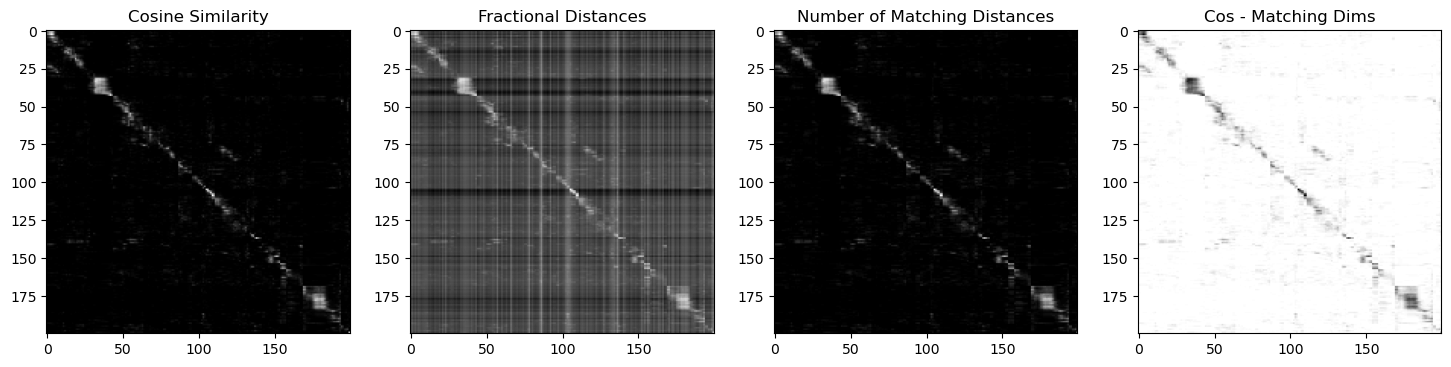

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18, 18))

ax1.imshow(np.transpose(cos_sim_SEER_2), cmap='gray')
ax1.set_title("Cosine Similarity")

ax2.imshow(results_fractional_SEER_2 * -1, cmap='gray')
ax2.set_title("Fractional Distances")

ax3.imshow(results_match_dims_SEER_2, cmap='gray')
ax3.set_title("Number of Matching Distances")

ax4.imshow(np.transpose(cos_sim_SEER_2) - results_match_dims_SEER_2, cmap='gray')
ax4.set_title("Cos - Matching Dims")

In [17]:
def get_common_indices(sparsem1, sparsem2):
    
    # Find the intersection of the non-zero indices
    set1 = set(zip(sparsem1.row, sparsem1.col))
    set2 = set(zip(sparsem2.row, sparsem2.col))
    common_indices = set1 & set2
    return common_indices

In [18]:
def get_values_on_common_dimension(sparsem1, sparsem2):
    common_indices = get_common_indices(sparsem1, sparsem2)
    
    common_values1 = []
    common_values2 = []

    for row, col in common_indices:
        index1 = np.where((sparsem1.row == row) & (sparsem1.col == col))[0][0]
        index2 = np.where((sparsem2.row == row) & (sparsem2.col == col))[0][0]
        common_values1.append(sparsem1.data[index1])
        common_values2.append(sparsem2.data[index2])
    return common_values1, common_values2

In [19]:
def distance_on_matching_dims(sparsem1, sparsem2, k):
    common_values1, common_values2 = get_values_on_common_dimension(sparsem1, sparsem2)
    
    result = fractional_distance(k, common_values1, common_values2)
    return result

In [20]:
def compute_dist_on_matching_dimensions_sequential(Xin, Yin, k):
    result_Matrix = np.full((Xin.shape[0], Yin.shape[0]), 100, dtype=np.float32)
    for i in range (Xin.shape[0]):
        for j in range (Yin.shape[0]):
            matrix1_coo = Xin[i].tocoo()
            matrix2_coo = Yin[j].tocoo()
            dist = distance_on_matching_dims(matrix1_coo, matrix2_coo, k)
            result_Matrix[j][i] = dist
    return result_Matrix

In [32]:
start = perf_counter()
results_match_dims__dist_SEER_2 = compute_dist_on_matching_dimensions_sequential(sparse_DB, sparse_query, 2/5)
end = perf_counter()
duration = end - start
print(f"Duration Sequential distance on matching dimensions: {duration} seconds")

Duration Sequential distance on matching dimensions: 4.180349624999508 seconds


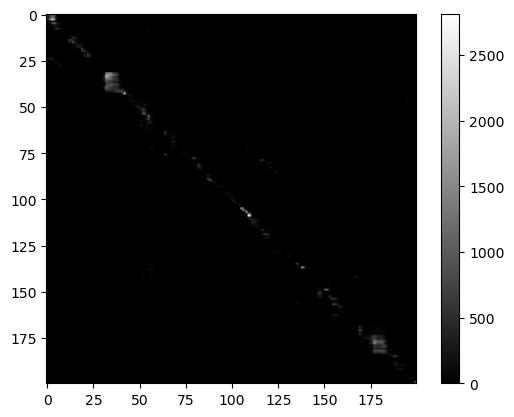

In [33]:
print_gs_matrix(results_match_dims__dist_SEER_2)

In [34]:
np.max(results_match_dims__dist_SEER_2)

2814.9014

In [21]:
# public dictionary of dimension ranges in the format of {dim: (max, min)}
# access: d[dimension][0=max, 1=min]
d = {}

In [22]:
def piDist_sequential(Xin, Yin):
    # iterate over all points
    result_Matrix = np.zeros((Xin.shape[0], Yin.shape[0]), dtype=np.float32)
    for i in range(Xin.shape[0]):
        for j in range(Yin.shape[0]):
            similarity = 0
            matrix1_coo = Xin[i].tocoo()
            matrix2_coo = Yin[j].tocoo()
            # get common dimensions
            common_indices = get_common_indices(matrix1_coo, matrix2_coo)
            valuesX, valuesY = get_values_on_common_dimension(matrix1_coo, matrix2_coo)
            # get or compute dimension ranges
            for row, col in common_indices:
                #columns are the dimensions of the original dataset
                index1 = np.where((matrix1_coo.row == row) & (matrix1_coo.col == col))[0][0]
                index2 = np.where((matrix2_coo.row == row) & (matrix2_coo.col == col))[0][0]
                if col in d.keys():
                    #lookup min and max
                    v_max = d[col][0]
                    v_min = d[col][1]
                else:
                    #get values, store in d and
                    #get max value
                    v_max = np.max(Xin[:,0].toarray())
                    #get min value
                    v_min = np.min(Xin[:,0].toarray()[np.nonzero(Xin[:,0].toarray())])
                    d[col] = (v_max, v_min)
                # calculate similarity using (1 - (xi - qi)/(imax - imin))
                similarity += 1 - ((matrix1_coo.data[index1] - matrix2_coo.data[index2]) / (v_max - v_min))
            result_Matrix[j][i] = similarity
    return result_Matrix

In [37]:
start = perf_counter()
results_pidist_SEER_2 = piDist_sequential(sparse_DB, sparse_query)
end = perf_counter()
duration = end - start
print(f"Duration Sequential pidist: {duration} seconds")

Duration Sequential pidist: 5.968916333004017 seconds


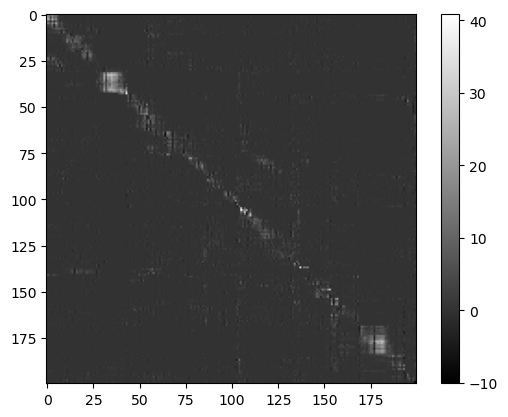

In [38]:
print_gs_matrix(results_pidist_SEER_2)

In [23]:
def calc_hard_matrix(matrix):
    # Find the indices of the maximum values in each row
    max_indices = np.argmax(matrix, axis=1)

    # Create a new matrix with the same shape, filled with zeros
    result = np.zeros_like(matrix)

    # Set the maximum values to 1
    result[np.arange(matrix.shape[0]), max_indices] = 1
    return result

In [24]:
def print_gs_matrix_hard(matrix):
    result = calc_hard_matrix(matrix)
    plt.imshow(result, cmap='gray')
    plt.colorbar()
    plt.show()

In [25]:
differences_pidist = np.zeros(200)
for i in range(results_pidist_SEER_2.shape[0]):
    difference = np.abs(np.argmax(results_pidist_SEER_2[i]) - i)
    differences_pidist[i] = difference 
    
differences_dist_match = np.zeros(200)
for i in range(results_match_dims__dist_SEER_2.shape[0]):
    difference = np.abs(np.argmax(results_match_dims__dist_SEER_2[i]) - i)
    differences_dist_match[i] = difference
    

differences_dist_match_count = np.zeros(200)
for i in range(results_match_dims_SEER_2.shape[0]):
    difference = np.abs(np.argmax(results_match_dims_SEER_2[i]) - i)
    differences_dist_match_count[i] = difference

NameError: name 'results_pidist_SEER_2' is not defined

Text(0.5, 1.0, 'Binary Plot Distance on Matching Distances (k = 2/5)')

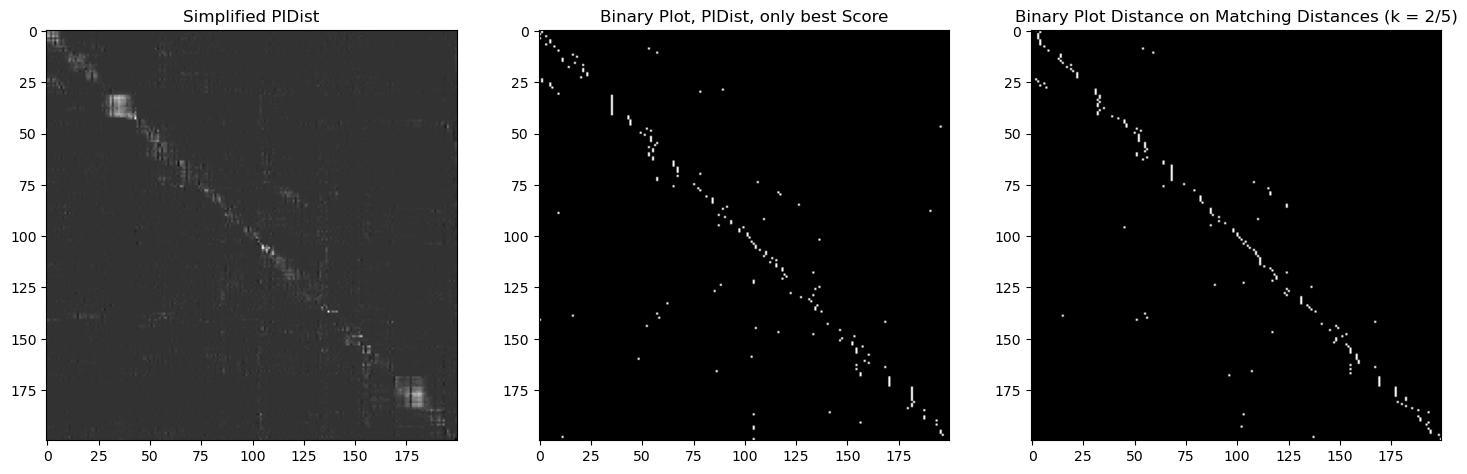

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 18))

ax1.imshow(results_pidist_SEER_2, cmap='gray')
ax1.set_title("Simplified PIDist")

ax2.imshow(calc_hard_matrix(results_pidist_SEER_2), cmap='gray')
ax2.set_title("Binary Plot, PIDist, only best Score")

ax3.imshow(calc_hard_matrix(results_match_dims__dist_SEER_2), cmap='gray')
ax3.set_title("Binary Plot Distance on Matching Distances (k = 2/5)")





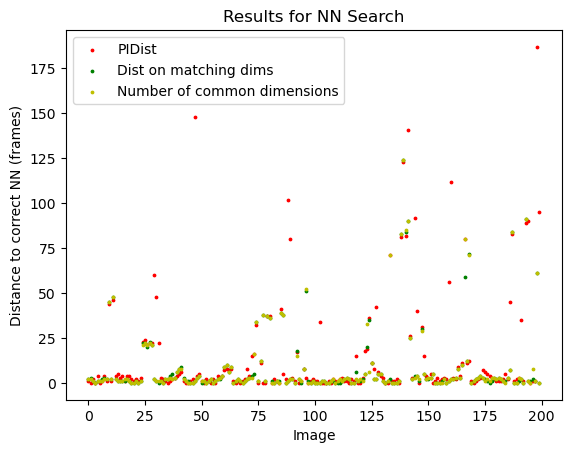

In [43]:
X = np.arange(0, 200)

plt.scatter(X, differences_pidist, color='r', s=3, label='PIDist')
plt.scatter(X, differences_dist_match, color='g', s=3, label='Dist on matching dims')
plt.scatter(X, differences_dist_match_count, color = 'y', s=3, label='Number of common dimensions')

plt.xlabel("Image")
plt.ylabel("Distance to correct NN (frames)")
plt.title("Results for NN Search")

plt.legend()
plt.show()

In [44]:
print(np.count_nonzero(differences_pidist==0))
print(np.count_nonzero(differences_dist_match==0))
print(np.count_nonzero(differences_dist_match_count==0))

32
42
43


In [45]:
print(np.count_nonzero(differences_pidist<8))
print(np.count_nonzero(differences_dist_match<8))
print(np.count_nonzero(differences_dist_match_count<8))

143
161
159


In [34]:
summer_seer = sp.load_npz(nl_summer_seer_path)
q_spring_summer = sp.load_npz('./data/nordland/seer/q_spring_m_summer.npz')

In [35]:
start = perf_counter()
results_match_dims_nl_summer_spring = compute_matching_dimensions_sequential(summer_seer, q_spring_summer)
end = perf_counter()
duration = end - start
print(f"Duration Sequential matching dimensions: {duration} seconds")

Duration Sequential matching dimensions: 1494.51801062499 seconds


In [37]:
summer_seer[0]

<1x706 sparse matrix of type '<class 'numpy.float64'>'
	with 50 stored elements in Compressed Sparse Row format>

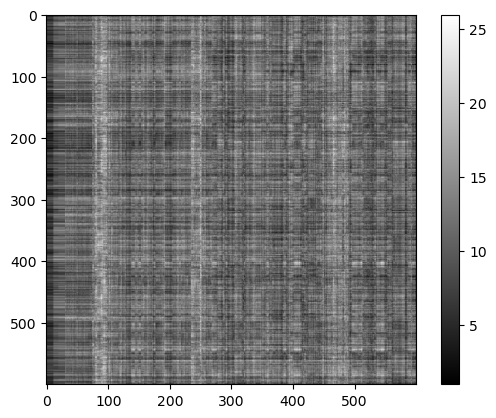

In [38]:
print_gs_matrix(results_match_dims_nl_summer_spring)

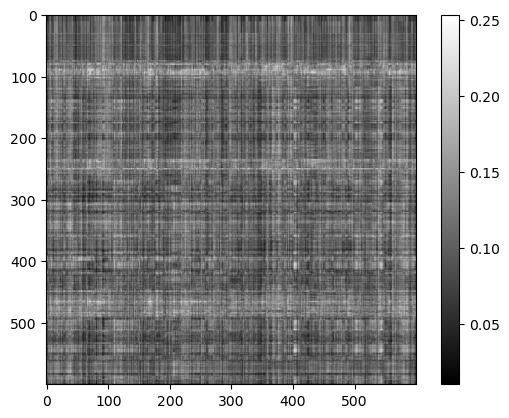

In [40]:
cos_sim_nl = sequential_cos_sim(summer_seer, q_spring_summer)
print_gs_matrix(cos_sim_nl)